In [1]:
import pandas as pd
import numpy as np
import time
from memory_profiler import memory_usage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from gensim.models import KeyedVectors
import psutil



df = pd.read_csv(r"DATA.csv", encoding='ISO-8859-1')
df = df.drop("1467810369",axis=1)

In [2]:
df.columns = ['polarity', 'date', 'query', 'user', 'text']

df.head()

,polarity,date,query,user,text
0,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df = df.drop(["query","date","user"],axis=1)

In [4]:
df.head()

,polarity,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [5]:
df.tail()

,polarity,text
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
print("Shape of the DataFrame:", df.shape)
print("\nPolarity Value Counts:")
print(df["polarity"].value_counts())
print("\nUnique Values in 'polarity' column:")
print(df["polarity"].unique())
print("\nMissing (null) Values in the DataFrame:")
print(df.isnull().sum())


Shape of the DataFrame: (1599999, 2)

Polarity Value Counts:
4    800000
0    799999
Name: polarity, dtype: int64

Unique Values in 'polarity' column:
[0 4]

Missing (null) Values in the DataFrame:
polarity    0
text        0
dtype: int64


In [7]:
df["polarity"] = df["polarity"].replace(4, 1)

In [8]:
print("Shape of the DataFrame:", df.shape)
print("\nPolarity Value Counts:")
print(df["polarity"].value_counts())
print("\nUnique Values in 'polarity' column:")
print(df["polarity"].unique())
print("\nMissing (null) Values in the DataFrame:")
print(df.isnull().sum())


Shape of the DataFrame: (1599999, 2)

Polarity Value Counts:
1    800000
0    799999
Name: polarity, dtype: int64

Unique Values in 'polarity' column:
[0 1]

Missing (null) Values in the DataFrame:
polarity    0
text        0
dtype: int64


In [9]:
X = df['text']
y = df['polarity']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_df = pd.DataFrame({'text': X_train, 'polarity': y_train})
val_df = pd.DataFrame({'text': X_val, 'polarity': y_val})
test_df = pd.DataFrame({'text': X_test, 'polarity': y_test})

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

url_pattern = re.compile(r'http\S+|www\S+')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')
special_char_pattern = re.compile(r'[^a-zA-Z\s]')
extra_whitespace_pattern = re.compile(r'\s+')

def preprocess_tweet(tweet):
    tweet = url_pattern.sub('', tweet)
    tweet = mention_pattern.sub('', tweet)
    tweet = hashtag_pattern.sub('', tweet)
    tweet = special_char_pattern.sub('', tweet.lower())

    tokens = [lemmatizer.lemmatize(word) for word in tweet.split() if word not in stop_words]

    return extra_whitespace_pattern.sub(' ', ' '.join(tokens)).strip()


Remove URLs

Remove Mentions

Remove Hashtags

Remove Special Characters and Lowercasing     

Remove Stopwords , Tokenization , Lemmatization

Remove Extra Whitespaces

In [11]:
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
sample_size = 0.5

train_df = train_df.groupby(train_df.iloc[:, 1]).apply(lambda x: x.sample(frac=sample_size, random_state=42)).reset_index(drop=True)
test_df = test_df.groupby(test_df.iloc[:, 1]).apply(lambda x: x.sample(frac=sample_size, random_state=42)).reset_index(drop=True)
val_df = val_df.groupby(val_df.iloc[:, 1]).apply(lambda x: x.sample(frac=sample_size, random_state=42)).reset_index(drop=True)

print(train_df.iloc[:, 1].value_counts(normalize=True))
print(test_df.iloc[:, 1].value_counts(normalize=True))
print(val_df.iloc[:, 1].value_counts(normalize=True))

1    0.5
0    0.5
Name: polarity, dtype: float64
1    0.5
0    0.5
Name: polarity, dtype: float64
1    0.5
0    0.5
Name: polarity, dtype: float64


In [13]:
train_df['text'] = train_df['text'].apply(preprocess_tweet)
val_df['text'] = val_df['text'].apply(preprocess_tweet)
test_df['text'] = test_df['text'].apply(preprocess_tweet)

In [14]:
train_texts, train_labels = train_df["text"], train_df["polarity"]
test_texts, test_labels = test_df["text"], test_df["polarity"]
val_texts, val_labels = val_df["text"], val_df["polarity"]

In [15]:
train_texts = train_texts.astype(str)
test_texts = test_texts.astype(str)
val_texts = val_texts.astype(str)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

In [16]:
total_words = sum(tokenizer.word_counts.values())
sorted_counts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)

cumulative_freq = 0
threshold = 0.95 * total_words
num_words = 0

for word, count in sorted_counts:
    cumulative_freq += count
    num_words += 1
    if cumulative_freq >= threshold:
        break

print(f"num_words to cover 95% of the word occurrences: {num_words}")

num_words to cover 95% of the word occurrences: 31378


The cell above help us identify number of words in the below cell

In [17]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_texts)

vocab_size = len(tokenizer.word_index) + 1
print(f"Final vocabulary size: {vocab_size}")

Final vocabulary size: 211064


In [18]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

Convert Text to sequence of Numeric Format

In [19]:
sequence_lengths = [len(seq) for seq in train_sequences]

print(f"Max length: {np.max(sequence_lengths)}")

Max length: 34


The cell above help us identify sequence_lengths in the below cell

In [20]:
max_sequence_length = np.max(sequence_lengths)
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length)

Make all input data of the same shape by padding or truncating

In [21]:
trainable_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_sequence_length, trainable=True),
    LSTM(128, dropout=0.4, recurrent_dropout=0),
    Dense(1, activation="sigmoid")
])

trainable_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
trainable_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            10553200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 10,644,977
Trainable params: 10,644,977
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_weights.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [23]:
trainable_model.fit(train_padded, train_labels, 
                    epochs=50, batch_size=64, 
                    validation_data=(val_padded, val_labels),
                    callbacks=[early_stop, model_checkpoint])

Epoch 1/50
10000/10000 [==============================] - 158s 16ms/step - loss: 0.4740 - accuracy: 0.7720 - val_loss: 0.4566 - val_accuracy: 0.7838

Epoch 00001: val_loss improved from inf to 0.45655, saving model to model_checkpoints\best_weights.h5
Epoch 2/50
10000/10000 [==============================] - 155s 15ms/step - loss: 0.4380 - accuracy: 0.7951 - val_loss: 0.4497 - val_accuracy: 0.7875

Epoch 00002: val_loss improved from 0.45655 to 0.44965, saving model to model_checkpoints\best_weights.h5
Epoch 3/50
10000/10000 [==============================] - 154s 15ms/step - loss: 0.4215 - accuracy: 0.8044 - val_loss: 0.4464 - val_accuracy: 0.7909

Epoch 00003: val_loss improved from 0.44965 to 0.44642, saving model to model_checkpoints\best_weights.h5
Epoch 4/50
10000/10000 [==============================] - 154s 15ms/step - loss: 0.4089 - accuracy: 0.8121 - val_loss: 0.4479 - val_accuracy: 0.7914

Epoch 00004: val_loss did not improve from 0.44642
Epoch 5/50
10000/10000 [===========

In [24]:
# LSTM Layer Parameters
lstm_weights = trainable_model.layers[1].get_weights()
W_i, U_i, b_i = lstm_weights[0][:, :128], lstm_weights[1][:, :128], lstm_weights[2][:128]  # Input gate
W_f, U_f, b_f = lstm_weights[0][:, 128:256], lstm_weights[1][:, 128:256], lstm_weights[2][128:256]  # Forget gate
W_c, U_c, b_c = lstm_weights[0][:, 256:384], lstm_weights[1][:, 256:384], lstm_weights[2][256:384]  # Cell state
W_o, U_o, b_o = lstm_weights[0][:, 384:], lstm_weights[1][:, 384:], lstm_weights[2][384:]  # Output gate

# Dense Layer Parameters
dense_weights, dense_bias = trainable_model.layers[2].get_weights()

Extract Model Weights for the forward pass

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def LSTM_forward(inputs, mask=None):
    timesteps, input_dim = inputs.shape
    h_t = np.zeros((128,))  # Initialize hidden state
    c_t = np.zeros((128,))  # Initialize cell state

    for t in range(timesteps):
        if mask is not None and mask[t] == 0:
            continue  # Skip this timestep if masked

        x_t = inputs[t]

        # Input gate
        i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i)
        # Forget gate
        f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f)
        # Cell state update
        c_hat_t = np.tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c)
        c_t = f_t * c_t + i_t * c_hat_t
        # Output gate
        o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o)
        # Hidden state update
        h_t = o_t * np.tanh(c_t)

    # Dense layer forward pass
    dense_output = sigmoid(np.dot(h_t, dense_weights) + dense_bias)
    return dense_output

def predict(batch):
    # Pass the batch through the embedding layer
    embeddings = trainable_model.layers[0](batch).numpy()
    mask = (batch != 0).astype(int)  # Create mask (assuming 0 is the padding token)

    predictions = []
    for i in range(embeddings.shape[0]):  # Process each sequence
        pred = LSTM_forward(embeddings[i], mask=mask[i])
        predictions.append(pred)

    return np.array(predictions)


In [26]:
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)

sample_data = test_padded

threshold = 0.5

# Model predictions
start_time = time.time()
start_memory = get_memory_usage()
model_preds = trainable_model.predict(sample_data)
model_classes = (model_preds >= threshold).astype(int)
model_memory = get_memory_usage() - start_memory
model_time = time.time() - start_time

# Custom predictions
start_time = time.time()
start_memory = get_memory_usage()
custom_preds = predict(sample_data)
custom_classes = (custom_preds >= threshold).astype(int)
custom_memory = get_memory_usage() - start_memory
custom_time = time.time() - start_time

print("Model Classes:", model_classes.flatten())
print("Custom Classes:", custom_classes.flatten())

accuracy = np.mean(model_classes == custom_classes)
print(f"Accuracy of Custom Predictions: {accuracy * 100:.2f}%")

print(f"Custom Function Time: {custom_time:.4f} seconds")
print(f"Model Function Time: {model_time:.4f} seconds")
print(f"Custom Function Memory: {custom_memory:.4f} MB")
print(f"Model Function Memory: {model_memory:.4f} MB")

Model Classes: [0 0 0 ... 1 1 0]
Custom Classes: [0 0 0 ... 1 1 0]
Accuracy of Custom Predictions: 98.69%
Custom Function Time: 216.5089 seconds
Model Function Time: 4.2239 seconds
Custom Function Memory: 1.7656 MB
Model Function Memory: 8.4648 MB


The custom implementation achieves high accuracy, nearly identical to the trained model.The minor differences (accuracy less than 100%) may arise due to:

Numerical precision differences between NumPy operations and TensorFlow optimizations.

The manual sigmoid and tanh functions might have slight deviations compared to their TensorFlow counterparts.

1) TensorFlow Optimization:

TensorFlow is highly optimized for GPU and parallelized computation, enabling rapid forward passes for batches of data. It leverages cuDNN, to process LSTM computations efficiently.

2) Custom Function:

The custom function processes the input sequentially for each timestep and sequence, leading to significant overhead.
It runs on the CPU using NumPy, which is not optimized for deep learning computations.
Masking is implemented manually, adding additional computation for each timestep.

1) TensorFlow's Overheads:

TensorFlow allocates additional memory for internal graph representations, tensors, and other intermediate computations to optimize performance and enable gradient computations.

2) Custom Function :
The custom function only computes the forward pass without the overhead of maintaining computational graphs or intermediate states.
It uses NumPy arrays, which have lower memory overhead compared to TensorFlow's tensor objects.

In [27]:
trainable_acc = trainable_model.evaluate(test_padded, test_labels, batch_size=64)
print(f"Trainable Embeddings Model Accuracy: {trainable_acc[1]:.4f}")

1250/1250 [==============================] - 5s 4ms/step - loss: 0.4447 - accuracy: 0.7909
Trainable Embeddings Model Accuracy: 0.7909


In [28]:
y_pred_probs = trainable_model.predict(test_padded, batch_size=64)
y_pred = (y_pred_probs > 0.5).astype("int32")

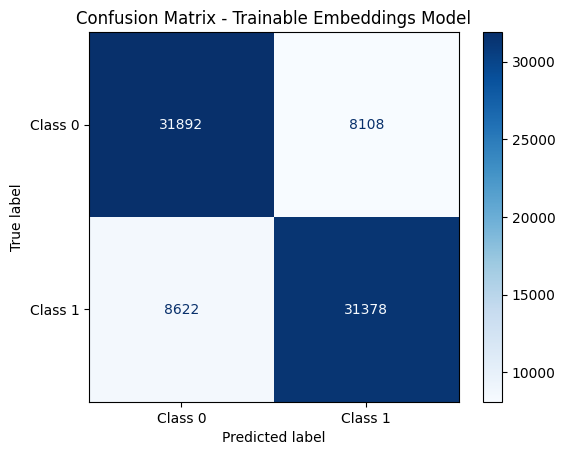

In [29]:
conf_mat = confusion_matrix(test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Trainable Embeddings Model")
plt.show()

In [30]:
report = classification_report(test_labels, y_pred, target_names=["Class 0", "Class 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79     40000
     Class 1       0.79      0.78      0.79     40000

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



In [31]:
model_path = r"C:\Users\Essam\Desktop\DL Assignment2\Word2vec\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [32]:
unmatched_count = 0
matched_count = 0

for word in tokenizer.word_index.keys():
    if word in word2vec_model:
        matched_count += 1
    else:
        unmatched_count += 1

print(f"Matched tokens: {matched_count}")
print(f"Unmatched tokens (OOV): {unmatched_count}")


Matched tokens: 47929
Unmatched tokens (OOV): 163134


number of words not covered by word2vec embedding

In [33]:
def build_embedding_matrix(word_index, embedding_dim=300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    return embedding_matrix

embedding_matrix = build_embedding_matrix(tokenizer.word_index)

pretrained_model = Sequential([
    Embedding(input_dim=len(embedding_matrix),
              output_dim=300, input_length=max_sequence_length,
              weights=[embedding_matrix], trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0),
    Dense(1, activation="sigmoid")
])

pretrained_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 300)           63319200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 63,538,977
Trainable params: 219,777
Non-trainable params: 63,319,200
_________________________________________________________________


In [35]:
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

early_stop_pretrained  = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
model_checkpoint_pretrained  = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_weights_pretrained.weights.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [36]:
pretrained_model.fit(train_padded, train_labels,
                    epochs=50, batch_size=64,
                    validation_data=(val_padded, val_labels),
                    callbacks=[early_stop_pretrained, model_checkpoint_pretrained])

Epoch 1/50
10000/10000 [==============================] - 65s 6ms/step - loss: 0.4933 - accuracy: 0.7585 - val_loss: 0.4660 - val_accuracy: 0.7782

Epoch 00001: val_loss improved from inf to 0.46602, saving model to model_checkpoints\best_weights_pretrained.weights.h5
Epoch 2/50
10000/10000 [==============================] - 63s 6ms/step - loss: 0.4591 - accuracy: 0.7810 - val_loss: 0.4541 - val_accuracy: 0.7841

Epoch 00002: val_loss improved from 0.46602 to 0.45410, saving model to model_checkpoints\best_weights_pretrained.weights.h5
Epoch 3/50
10000/10000 [==============================] - 63s 6ms/step - loss: 0.4440 - accuracy: 0.7900 - val_loss: 0.4477 - val_accuracy: 0.7878

Epoch 00003: val_loss improved from 0.45410 to 0.44771, saving model to model_checkpoints\best_weights_pretrained.weights.h5
Epoch 4/50
10000/10000 [==============================] - 63s 6ms/step - loss: 0.4328 - accuracy: 0.7967 - val_loss: 0.4451 - val_accuracy: 0.7894

Epoch 00004: val_loss improved from 0

In [43]:
# Extract LSTM Layer Parameters from the pretrained model
lstm_weights = pretrained_model.layers[1].get_weights()
W_i, U_i, b_i = lstm_weights[0][:, :128], lstm_weights[1][:, :128], lstm_weights[2][:128]  # Input gate
W_f, U_f, b_f = lstm_weights[0][:, 128:256], lstm_weights[1][:, 128:256], lstm_weights[2][128:256]  # Forget gate
W_c, U_c, b_c = lstm_weights[0][:, 256:384], lstm_weights[1][:, 256:384], lstm_weights[2][256:384]  # Cell state
W_o, U_o, b_o = lstm_weights[0][:, 384:], lstm_weights[1][:, 384:], lstm_weights[2][384:]  # Output gate

# Extract Dense Layer Parameters from the pretrained model
dense_weights, dense_bias = pretrained_model.layers[2].get_weights()

In [44]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def LSTM_forward(inputs, mask=None):
    timesteps, input_dim = inputs.shape
    h_t = np.zeros((128,))  # Initialize hidden state
    c_t = np.zeros((128,))  # Initialize cell state

    for t in range(timesteps):
        if mask is not None and mask[t] == 0:
            continue  # Skip this timestep if masked

        x_t = inputs[t]

        # Input gate
        i_t = sigmoid(np.dot(x_t, W_i) + np.dot(h_t, U_i) + b_i)
        # Forget gate
        f_t = sigmoid(np.dot(x_t, W_f) + np.dot(h_t, U_f) + b_f)
        # Cell state update
        c_hat_t = np.tanh(np.dot(x_t, W_c) + np.dot(h_t, U_c) + b_c)
        c_t = f_t * c_t + i_t * c_hat_t
        # Output gate
        o_t = sigmoid(np.dot(x_t, W_o) + np.dot(h_t, U_o) + b_o)
        # Hidden state update
        h_t = o_t * np.tanh(c_t)

    # Dense layer forward pass
    dense_output = sigmoid(np.dot(h_t, dense_weights) + dense_bias)
    return dense_output
def predict(batch):
    # Pass the batch through the embedding layer of the pretrained model
    embeddings = pretrained_model.layers[0](batch).numpy()
    mask = (batch != 0).astype(int)  # Create mask (assuming 0 is the padding token)

    predictions = []
    for i in range(embeddings.shape[0]):  # Process each sequence
        pred = LSTM_forward(embeddings[i], mask=mask[i])
        predictions.append(pred)

    return np.array(predictions)


In [46]:
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)

threshold = 0.5

sample_data = test_padded[:1000]

# Model predictions
start_time = time.time()
start_memory = get_memory_usage()
model_preds = pretrained_model.predict(sample_data)
model_classes = (model_preds >= threshold).astype(int)
model_memory = get_memory_usage() - start_memory
model_time = time.time() - start_time

# Custom predictions
start_time = time.time()
start_memory = get_memory_usage()
custom_preds = predict(sample_data)
custom_classes = (custom_preds >= threshold).astype(int)
custom_memory = get_memory_usage() - start_memory
custom_time = time.time() - start_time

print("Model Classes:", model_classes.flatten())
print("Custom Classes:", custom_classes.flatten())

accuracy = np.mean(model_classes == custom_classes)
print(f"Accuracy of Custom Predictions: {accuracy * 100:.2f}%")

print(f"Custom Function Time: {custom_time:.4f} seconds")
print(f"Model Function Time: {model_time:.4f} seconds")
print(f"Custom Function Memory: {custom_memory:.4f} MB")
print(f"Model Function Memory: {model_memory:.4f} MB")


Model Classes: [1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0

In [47]:
test_loss, test_acc = pretrained_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_acc}")

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4422 - accuracy: 0.7927
Test Accuracy: 0.7927250266075134


In [48]:
test_preds = pretrained_model.predict(test_padded)
test_preds = (test_preds > 0.5).astype(int)

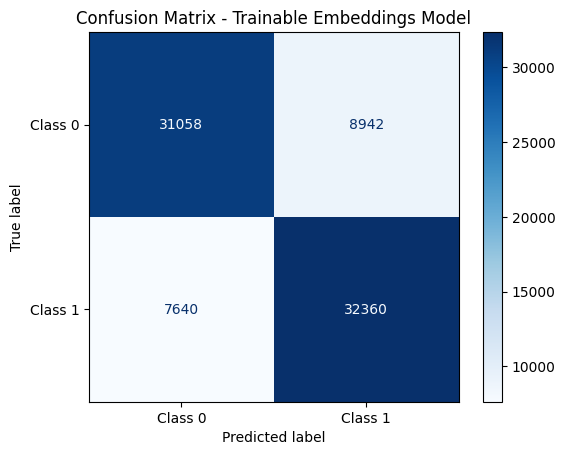

In [49]:
conf_mat = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Trainable Embeddings Model")
plt.show()

In [50]:
report = classification_report(test_labels, test_preds, target_names=["Negative", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.80      0.78      0.79     40000
    Positive       0.78      0.81      0.80     40000

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



### Both Models Trained and Pre-trained achieving simillar accuracies but the pretrained model is much faster as it is using pretrained embeddings 